This notebook extracts the resting-state temporal dynamics of brain networks.


We first use an atlas to construct a reasonably realistic model of interacting regions or nodes. We then use the atlas to mask BOLD activities of the nodes, remove confounds from the data, and finally extract the time-series for each node. This process ends up with a matrix of time-series of size n_subjects * n_nodes * n_timesteps, e.g., 32*39*125 in case of using regions of interest from \cite{@dosenbach2007}.


**WARNING**: *This notebook requires full BIDS dataset including fmriprep derivatives and preprocessed scans.*

In [25]:
import numpy as np
import xarray as xr
import pandas as pd

from bids import BIDSLayout

import nilearn
from nilearn import datasets, plotting, regions, maskers, image


In [ ]:
# load atlas
# TODO support multiple atlases via a fitting function
atlas = nilearn.datasets.fetch_atlas_yeo_2011()
# DEBUG atlas_yeo_2011.keys()

# merge voxels belonging to the same network based on spatial continuity
atlas_relabeled = nilearn.regions.connected_label_regions(atlas['thick_7'])

# atlas_relabeled

nilearn.plotting.plot_roi(
  atlas_relabeled,
	cut_coords=range(-30,70,10),
	display_mode='z',
	title='Yeo Atlas (voxels are re-labeled for continuity)')

atlas_coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_relabeled)
# atlas_resampled = nilearn.image.resample_to_img(atlas_relabeled, func)

# Steps: 
# 1. load atlas, 2. relabel atlas for continuity, 3. resample images, 4. mask and extract time series

In [27]:
# load resting-state session from the BIDS dataset

layout = BIDSLayout('data/julia2018_x5alias',
                    derivatives=True,
                    database_path='tmp/pybids_cache/julia2018')

subjects = layout.get_subject()
TR = layout.get_tr(task='rest')

images = layout.get(task='rest',
                    desc='preproc',
                    suffix='bold',
                    scope='fmriprep',
                    extension='nii.gz',
                    return_type='filename')

mask_images = layout.get(task='rest',
                         desc='brain',
                         suffix='mask',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

confounds_files = layout.get(task='rest',
                             desc='confounds',
                             suffix='timeseries',
                             scope='fmriprep',
                             extension='tsv',
                             return_type='filename')

confounds_cols = ['trans_x', 'trans_y', 'trans_z',
                  'csf', 'whitematter',
                  'rot_x', 'rot_y', 'rot_z',
                  'global_signal',
                  'a_comp_cor_00', 'a_comp_cor_01',
                  ]


In [84]:

# extract resting timeseries
import re
from tqdm import tqdm

timeseries = {}
subjects = []

for img, mask_img, confounds in tqdm(zip(images, mask_images, confounds_files)):

    subject = re.search('func/sub-(.*)_ses', img)[1]

    # resampled_atlas = nilearn.image.resample_to_img(atlas_relabeled, img)

    masker = nilearn.maskers.NiftiLabelsMasker(
        atlas_relabeled,
        mask_img=mask_img,
        detrend=True,
        standardize=True,
        t_r = TR,
        verbose=0)

        # for some reasons, using cache causes signal extraction to fail
        # memory='tmp/nilearn_cache', memory_level=1,

    confounds = pd.read_csv(confounds, sep='\t')[confounds_cols].values
    ts = masker.fit_transform(img, confounds=confounds).transpose(1, 0)
    timeseries[subject] = ts.T

# dim-0 is subject, dim-1 is region, dim-2 is time point
# timeseries = np.array(timeseries)

# plt.imshow(timeseries[0].T)
# plt.title('subject-00 time-series - {timeseries[0].shape[1]} regions')
# plt.show()
timeseries.keys()


0it [00:00, ?it/s]/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/maskers/nifti_labels_masker.py:462: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 3, 4, 5, 39, 9, 11, 48}. Label image only contains 42 labels (including background).
  warnings.warn("After resampling the label image to the "
1it [00:02,  2.81s/it]/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/maskers/nifti_labels_masker.py:462: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 3, 4, 5, 39, 9, 11, 48}. Label image only contains 42 labels (including background).
  warnings.warn("After resampling the label image to the "
2it [00:05,  2.86s/it]/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/maskers/nifti_labels_masker.py:462: UserWarning: After resampling the label image to the data image, the following labe

dict_keys(['AVGP01', 'AVGP02', 'AVGP03', 'AVGP04', 'AVGP05', 'AVGP08', 'AVGP10', 'AVGP12NEW', 'AVGP13', 'AVGP13NEW', 'AVGP14', 'AVGP14NEW', 'AVGP16NEW', 'AVGP17NEW', 'AVGP18', 'AVGP20', 'NVGP01', 'NVGP03', 'NVGP04', 'NVGP06', 'NVGP07', 'NVGP08', 'NVGP10', 'NVGP12', 'NVGP13', 'NVGP14', 'NVGP15', 'NVGP16', 'NVGP17', 'NVGP17NEW', 'NVGP19', 'NVGP19NEW'])

In [86]:
from nilearn import connectome
conn = connectome.ConnectivityMeasure(kind='correlation')
conn.fit_transform(timeseries.values())

np.fill_diagonal(conn.mean_, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# plotting.plot_matrix(conn.mean_, figure=(10, 8), labels=list(range(1,42)),
#                      vmax=0.8, vmin=-0.8, reorder=True)

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(conn.mean_,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')

TypeError: plot_connectome() missing 1 required positional argument: 'node_coords'

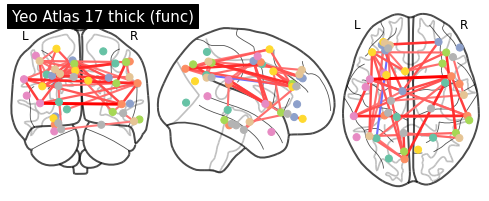

In [99]:
node_coords = pd.DataFrame(atlas_coordinates).drop(index=[32, 3, 4, 5, 39, 9, 11, 48]).values

plotting.plot_connectome(conn.mean_, node_coords,
                         edge_threshold="95%",
                         title='Yeo Atlas 17 thick (func)')
